<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/08_4%EA%B8%B0_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import kagglehub
import torch
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import random
import torchvision
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import sys
from matplotlib.colors import ListedColormap

# 0. 미션 설명

## 미션 소개
이번 미션에서는 U-Net을 이용해 축구 경기 영상 내의 다양한 객체(예: 골대, 심판, 선수, 관중 등)를 픽셀 단위로 분할하는 Semantic Segmentation 작업을 수행합니다. 실제 경기 장면에서 추출한 이미지를 바탕으로, 각 픽셀이 어떤 클래스에 속하는지 예측하는 모델을 직접 설계하고 학습해보세요.

## 데이터 소개
데이터 링크: Football (Semantic Segmentation) https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation/data
## 데이터 구성
본 데이터셋은 UEFA 슈퍼컵 2017 레알 마드리드 vs 맨체스터 유나이티드 경기 하이라이트 영상을 기반으로 수집된 축구 경기 장면들로 구성되어 있습니다. 총 100장의 프레임을 사용하였으며, 매 12번째 프레임을 추출해 흐릿한 장면이나 이상치는 일부 대체했습니다.

11개 클래스가 포함되어 있습니다.
- Goal Bar (골대)
- Referee (심판)
- Advertisement (광고판)
- Ground (잔디)
- Ball (축구공)
- Coaches & Officials (코칭 스태프 및 심판진)
- Audience (관중)
- Goalkeeper A (팀 A 골키퍼)
- Goalkeeper B (팀 B 골키퍼)
- Team A (팀 A 선수)
- Team B (팀 B 선수)

# 1. 데이터 불러오기 및 검토

In [3]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("온라인 Colab 환경(Google 서버)")
else:
    check_google_colab = False
    print("로컬 런타임 환경")

로컬 런타임 환경


In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    sub_path = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션8DATA"
    print("Google Colab 환경입니다.")
except ModuleNotFoundError:
    check_google_colab = False
    sub_path = "C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션8DATA"
    print("Local 환경입니다.")

Local 환경입니다.


## 구글 드라이브 경로 연결
- UEFA Super Cup 2017 (Real Madrid vs Manchester United) 파일들 구글 드라이브에 올리고 경로 설정

In [76]:
# 폴더 내 모든 파일 목록 가져오기
image_folder = os.path.join(sub_path, "images")
file_list = os.listdir(image_folder)

# 원본 이미지(.jpg)와 fuse 이미지 매칭
original_files = sorted([f for f in file_list if f.endswith(".jpg")])
fuse_files = sorted([f for f in file_list if "fuse" in f])

# 이미지 로드 및 확인
image_pairs = []
for orig_file in original_files:
    # 동일한 프레임의 fuse 파일 찾기
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        # 원본과 마스크 로드
        img_path = os.path.join(image_folder, orig_file)
        mask_path = os.path.join(image_folder, fuse_file)

#        img = cv2.imread(img_path)
        img_data = np.fromfile(str(img_path), dtype=np.uint8) # 한글과 띄어쓰기 경로 문제로 바이트로 먼저 처리
        image = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
#        mask = cv2.imread(mask_path)
        mask_data = np.fromfile(str(mask_path), dtype=np.uint8)
        mask = cv2.imdecode(mask_data, cv2.IMREAD_COLOR)

        if image is not None and mask is not None:
            image_pairs.append((image, mask, base_name))

# 최종적으로 로드된 이미지 쌍 개수 출력
print(f"{len(image_pairs)} pairs")

100 pairs


- 샘플 확인

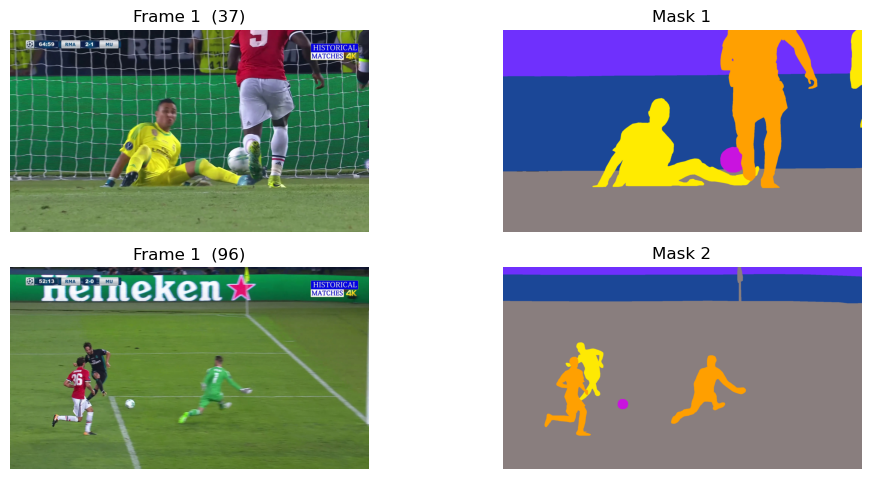

In [77]:
samples = random.sample(image_pairs, 2)  # 랜덤 2쌍 선택

plt.figure(figsize=(10, 12))
for i, (orig, mask, title) in enumerate(samples, 1):
    # BGR -> RGB
    img_rgb  = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 2, 2*i-1)
    plt.imshow(img_rgb)
    plt.title(f"{title}")
    plt.axis("off")

    plt.subplot(5, 2, 2*i)
    plt.imshow(mask_rgb)
#    plt.colorbar() # 이렇게 하면 안되는듯
    plt.title(f"Mask {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

- 마스크 팔레트 분류

In [78]:
mask = cv2.cvtColor(image_pairs[0][1], cv2.COLOR_BGR2RGB)
unique_color = np.unique(mask.reshape(-1, 3), axis=0)
print(f"Unique colors in mask[0]: {unique_color}")

Unique colors in mask[0]: [[ 27  71 151]
 [111  48 253]
 [254 233   3]
 [255   0  29]
 [255 159   0]
 [255 160   1]]


In [79]:
mask_colors=[]
for _, mask, _ in image_pairs:
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

    mask_colors.append(unique_colors)

all_colors = np.vstack(mask_colors)             # (N, 3)으로 이어붙임
unique_colors = np.unique(all_colors, axis=0)   # 중복 제거

print("전체 고유 색상:")
print(unique_colors)
print("개수:", len(unique_colors))

전체 고유 색상:
[[  0   0   0]
 [ 27  71 151]
 [111  48 253]
 [137 126 126]
 [201  19 223]
 [238 171 171]
 [254 233   3]
 [255   0  29]
 [255 159   0]
 [255 160   1]
 [255 235   0]]
개수: 11


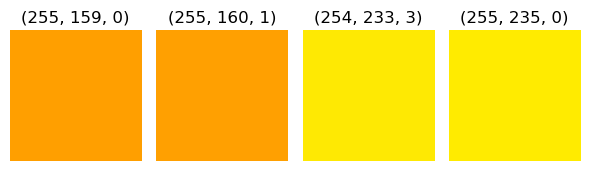

In [62]:
# 확인해봐야 할 색상
"""
 [255 159   0]
 [255 160   1]
 -------------
 [254 233   3]
 [255 235   0]
"""

colors = np.array([
    [255, 159,   0],
    [255, 160,   1],
    [254, 233,   3],
    [255, 235,   0]
], dtype=np.uint8)

plt.figure(figsize=(6,2))
for i, c in enumerate(colors):
    plt.subplot(1, len(colors), i+1)
    plt.imshow(np.full((50, 50, 3), c, dtype=np.uint8))
    plt.title(str(tuple(c)))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [57]:
def find_images_with_color(mask_list, target_color):
    results = []
    target_color = np.array(target_color, dtype=np.uint8)

    for idx, mask in enumerate(mask_list):
        # BGR → RGB 변환
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # 해당 색이 포함돼 있는지 확인
        if np.any(np.all(mask_rgb == target_color, axis=-1)):
            results.append((idx, mask))

    return results

mask_list = [m for _, m, _ in image_pairs]

target_color1 = (255, 159,   0)
target_color2 = (255, 160,   1)
target_color3 = (254, 233,   3)
target_color4 = (255, 235,   0)

found1 = find_images_with_color(mask_list, target_color1)
found2 = find_images_with_color(mask_list, target_color2)
found3 = find_images_with_color(mask_list, target_color3)
found4 = find_images_with_color(mask_list, target_color4)

print(f"색상 {target_color1} 이(가) 포함된 마스크 개수:", len(found1))
print(f"색상 {target_color2} 이(가) 포함된 마스크 개수:", len(found2))
print(f"색상 {target_color3} 이(가) 포함된 마스크 개수:", len(found3))
print(f"색상 {target_color4} 이(가) 포함된 마스크 개수:", len(found4))

#for idx, _ in found:
#    print(" → 포함된 이미지 index:", idx)

색상 (255, 159, 0) 이(가) 포함된 마스크 개수: 47
색상 (255, 160, 1) 이(가) 포함된 마스크 개수: 98
색상 (254, 233, 3) 이(가) 포함된 마스크 개수: 98
색상 (255, 235, 0) 이(가) 포함된 마스크 개수: 38


In [90]:
# 타깃 색 (RGB)
colorA = (255, 159,   0)
colorB = (255, 160,   1)

# 전역 팔레트 -> 색→인덱스 매핑
color2index = {tuple(map(int, c)): i for i, c in enumerate(unique_colors)}

def rgb_to_index(mask_rgb, color2index):
    h, w, _ = mask_rgb.shape
    idx = np.full((h, w), -1, dtype=np.int64)
    for c, k in color2index.items():
        idx[np.all(mask_rgb == c, axis=-1)] = k
    return idx

def has_color(mask_bgr, rgb):
    m = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    return np.any(np.all(m == rgb, axis=-1))

# 1) 두 색 각각이 들어있는 이미지 인덱스
idx_A = [i for i, (_, m, _) in enumerate(image_pairs) if has_color(m, colorA)]
idx_B = [i for i, (_, m, _) in enumerate(image_pairs) if has_color(m, colorB)]

# 2) 교집합(두 색 모두 포함)
both = sorted(set(idx_A) & set(idx_B))
print("두 색 모두 포함한 이미지 수:", len(both), " | 예시:", both[:10])

두 색 모두 포함한 이미지 수: 47  | 예시: [0, 2, 6, 8, 9, 10, 11, 14, 15, 16]


In [88]:
def build_color2index(unique_colors):
    return {tuple(int(x) for x in c): i for i, c in enumerate(unique_colors)}

def _to_rgb(img_bgr):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # 혹시 RGBA면 알파 제거
    if rgb.ndim == 3 and rgb.shape[2] == 4:
        rgb = rgb[..., :3]
    return rgb

def _rgb_to_index(mask_rgb, color2index):
    """RGB 팔레트 마스크(H,W,3) → 인덱스 마스크(H,W)"""
    h, w, _ = mask_rgb.shape
    idx = np.full((h, w), -1, dtype=np.int64)
    for c, k in color2index.items():
        idx[np.all(mask_rgb == c, axis=-1)] = k
    return idx

def show_pair_by_index(idx, image_pairs, class_names=None):
    """
    idx: image_pairs의 인덱스
    image_pairs: [(orig_bgr, mask_bgr, title), ...]
    class_names: {전역팔레트 인덱스:int -> "이름"} (선택)
    """
    orig_bgr, mask_bgr, title = image_pairs[idx]
    img_rgb  = _to_rgb(orig_bgr)
    mask_rgb = _to_rgb(mask_bgr)

    # 이 마스크에 실제 들어간 RGB 색들
    present_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
    present_colors_list = [tuple(int(x) for x in c) for c in present_colors]
    print(f"[idx={idx}] present RGB colors ({len(present_colors_list)}):")
    print(present_colors_list)

    # 전역 팔레트 기준으로 현재 프레임에 존재하는 클래스 인덱스만 추출
    present_idx = sorted([color2index[tuple(map(int, c))] for c in present_colors])
    # 시각화용 dense 인덱스(0..P-1)로 매핑
    idx_mask = _rgb_to_index(mask_rgb, color2index)
    dense = np.full_like(idx_mask, -1)
    for j, k in enumerate(present_idx):           # k: 전역 팔레트 인덱스
        color = tuple(int(x) for x in unique_colors[k])
        dense[np.all(mask_rgb == color, axis=-1)] = j

    # 현재 프레임에 존재하는 색들로만 컬러맵 구성
    cmap = ListedColormap((unique_colors[present_idx] / 255.0))

    # 라벨(컬러바) 구성: 클래스 이름 있으면 이름, 없으면 RGB 값
    labels = []
    for k in present_idx:
        if class_names and k in class_names:
            labels.append(class_names[k])
        else:
            labels.append(str(tuple(int(x) for x in unique_colors[k])))

    # ---- 플롯 ----
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img_rgb);  axes[0].axis("off")
    axes[0].set_title(f"{title} (idx={idx})")

    im = axes[1].imshow(dense, cmap=cmap, vmin=-0.5, vmax=len(present_idx)-0.5)
    axes[1].axis("off"); axes[1].set_title("Mask (present classes)")
    cbar = plt.colorbar(im, ax=axes[1], ticks=np.arange(len(present_idx)))
    cbar.set_ticklabels(labels)

    plt.tight_layout(); plt.show()


target_color1 = (255, 159,   0)
target_color2 = (255, 160,   1)
- 두 색 모두 포함한 이미지 수: 47  | 예시: [0, 2, 6, 8, 9, 10, 11, 14, 15, 16]

[idx=0] present RGB colors (6):
[(27, 71, 151), (111, 48, 253), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


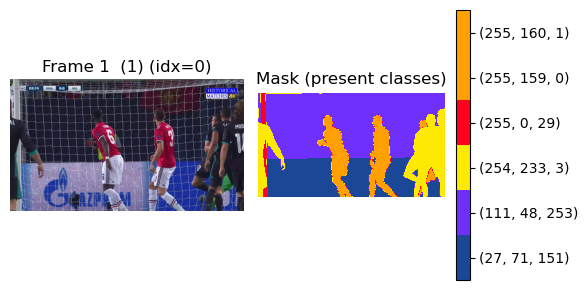

[idx=2] present RGB colors (10):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (238, 171, 171), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


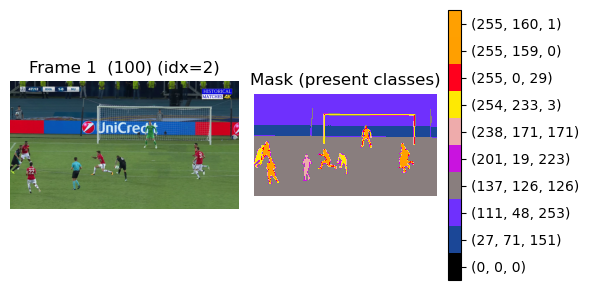

[idx=6] present RGB colors (6):
[(27, 71, 151), (111, 48, 253), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


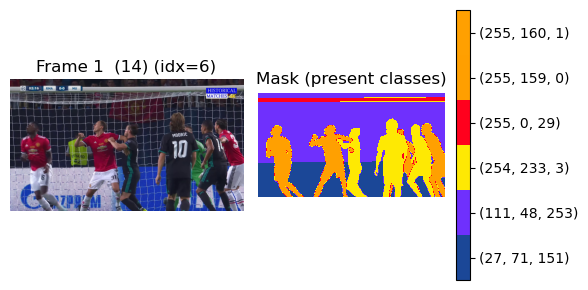

[idx=8] present RGB colors (9):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (238, 171, 171), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


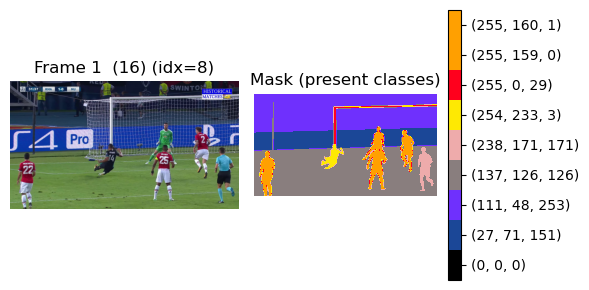

[idx=9] present RGB colors (10):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (238, 171, 171), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


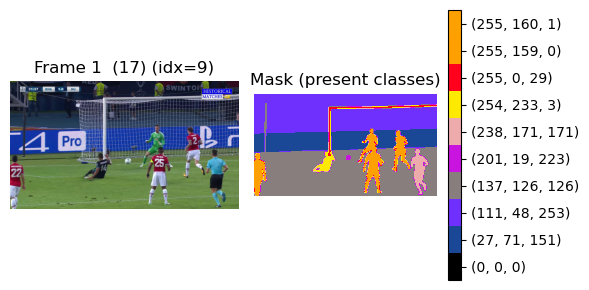

[idx=10] present RGB colors (10):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (238, 171, 171), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


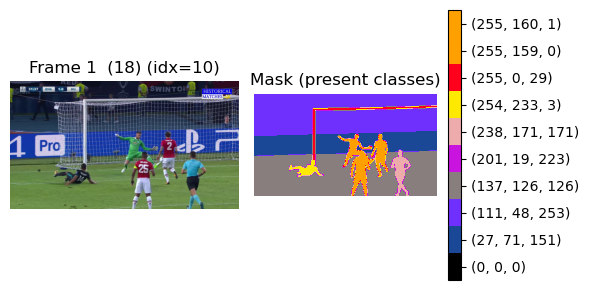

[idx=11] present RGB colors (9):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (238, 171, 171), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


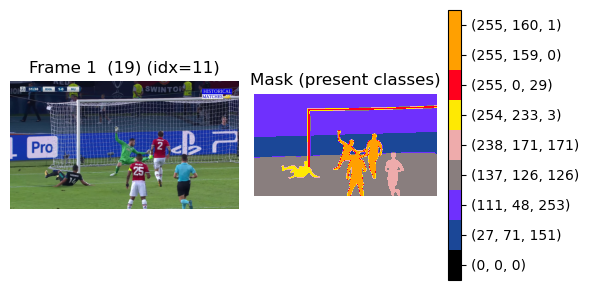

[idx=14] present RGB colors (7):
[(0, 0, 0), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


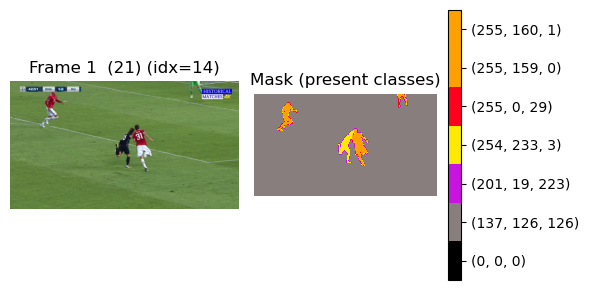

[idx=15] present RGB colors (7):
[(0, 0, 0), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


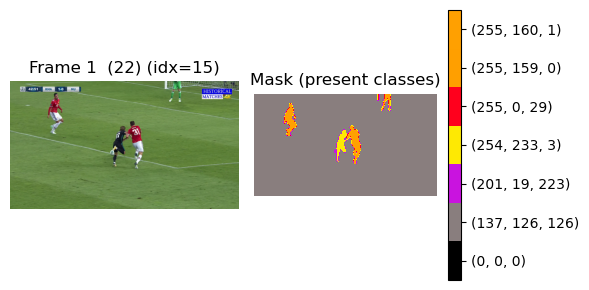

[idx=16] present RGB colors (8):
[(0, 0, 0), (27, 71, 151), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 0, 29), (255, 159, 0), (255, 160, 1)]


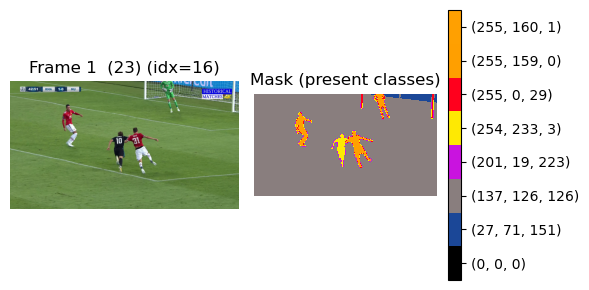

In [91]:
for i in [0, 2, 6, 8, 9, 10, 11, 14, 15, 16]:
    show_pair_by_index(i, image_pairs)

target_color3 = (254, 233,   3)
target_color4 = (255, 235,   0)
- 두 색 모두 포함한 이미지 수: 36  | 예시: [1, 3, 4, 5, 12, 21, 23, 25, 29, 30]

[idx=1] present RGB colors (7):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


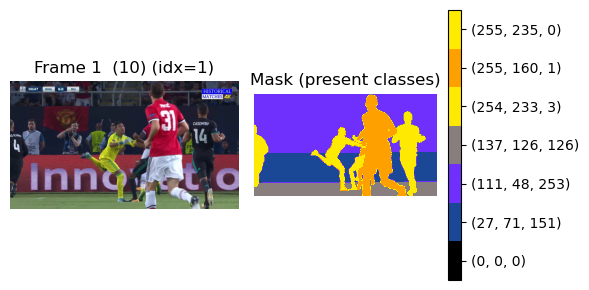

[idx=3] present RGB colors (7):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


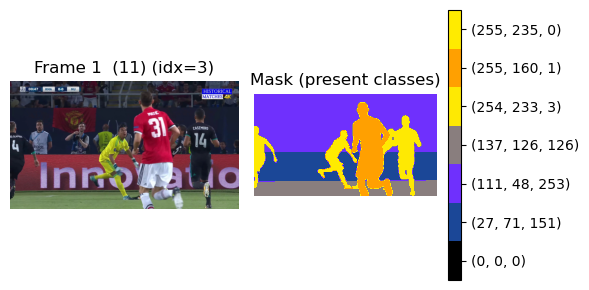

[idx=4] present RGB colors (7):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


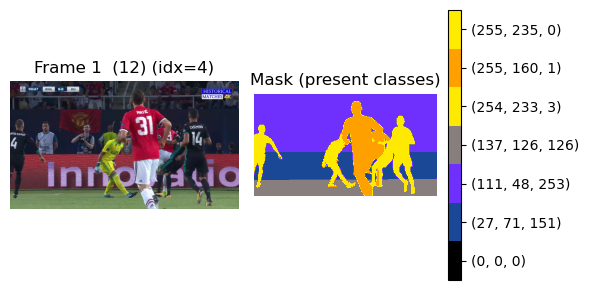

[idx=5] present RGB colors (7):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


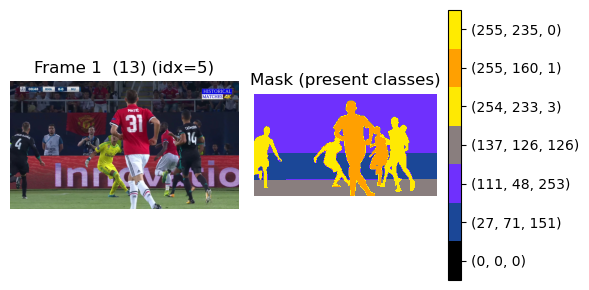

[idx=12] present RGB colors (7):
[(27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


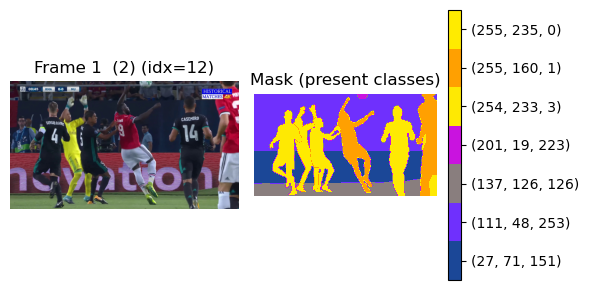

[idx=21] present RGB colors (9):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 0, 29), (255, 160, 1), (255, 235, 0)]


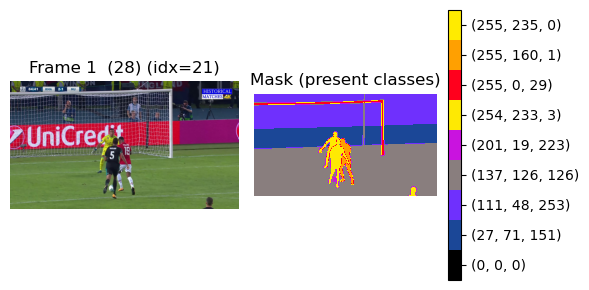

[idx=23] present RGB colors (7):
[(27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


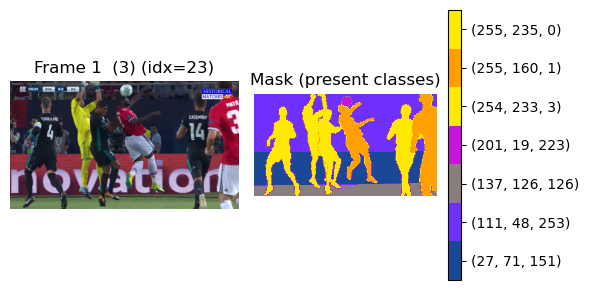

[idx=25] present RGB colors (8):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 160, 1), (255, 235, 0)]


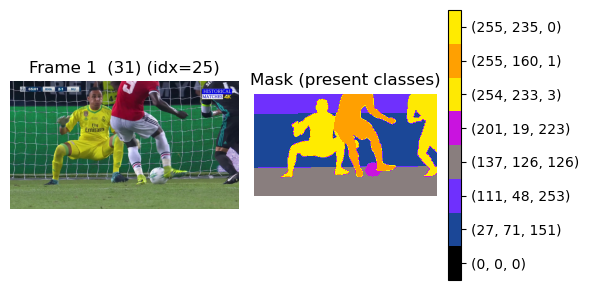

[idx=29] present RGB colors (10):
[(0, 0, 0), (27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (238, 171, 171), (254, 233, 3), (255, 0, 29), (255, 160, 1), (255, 235, 0)]


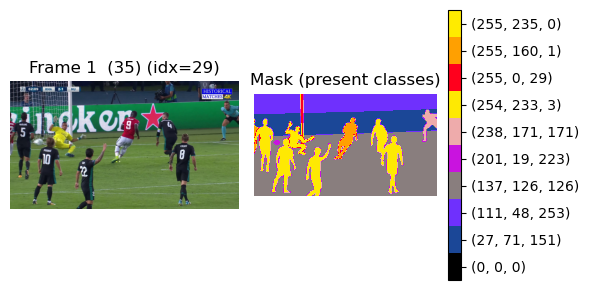

[idx=30] present RGB colors (8):
[(27, 71, 151), (111, 48, 253), (137, 126, 126), (201, 19, 223), (254, 233, 3), (255, 0, 29), (255, 160, 1), (255, 235, 0)]


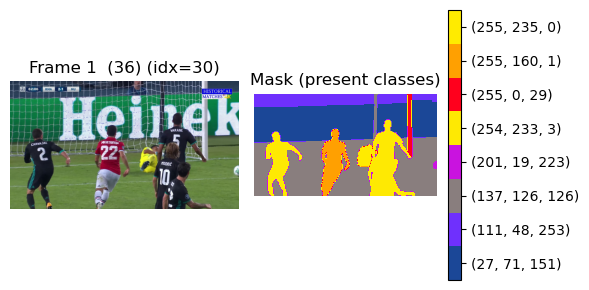

In [89]:
for i in [1, 3, 4, 5, 12, 21, 23, 25, 29, 30]:
    show_pair_by_index(i, image_pairs)

- 색이 비슷한 마스크 대상은 각 팀의 골키퍼인 부분 확인

In [97]:
# 각 라벨 클래스 이름 맵핑
# - Goal Bar (골대)
# - Referee (심판)
# - Advertisement (광고판)
# - Ground (잔디)
# - Ball (축구공)
# - Coaches & Officials (코칭 스태프 및 심판진)
# - Audience (관중)
# - Goalkeeper A (팀 A 골키퍼)
# - Goalkeeper B (팀 B 골키퍼)
# - Team A (팀 A 선수)
# - Team B (팀 B 선수)

color2name = {
    (0,   0,   0): "background",
    (27, 71, 151): "Advertisement (광고판)",
    (111, 48, 253): "Audience (관중)",
    (137,126,126): "Ground (잔디)",
    (201, 19, 223): "Ball (축구공)",
    (238,171,171): "Referee (심판)",
    (254,233,  3): "Goalkeeper A (팀 A 골키퍼)",
    (255,  0, 29): "Goal Bar (골대)",
    (255,159,  0): "Goalkeeper B (팀 B 골키퍼)",
    (255,160,  1): "Team B (팀 B 선수",
    (255,235,  0): "Team A (팀 A 선수)",
}

# 색상→인덱스 매핑 (학습용)
color2index = {c:i for i,c in enumerate(color2name.keys())}
index2name = {i:name for i,(c,name) in enumerate(color2name.items())}

def mask_to_class(mask_bgr, color2index):
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = mask_rgb.shape
    class_mask = np.zeros((h, w), dtype=np.int32)

    for color, idx in color2index.items():
        match = np.all(mask_rgb == color, axis=-1)
        class_mask[match] = idx
    return class_mask

In [101]:
major_labels = []
for _, mask_bgr, _ in image_pairs:   # (img_bgr, mask_bgr, img_name)
    cls_mask = mask_to_class(mask_bgr, color2index)
    unique, counts = np.unique(cls_mask, return_counts=True)
    dominant_class = unique[np.argmax(counts)]
    major_labels.append(dominant_class)